In [1]:
import nest
import numpy as np
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from utils.extractors import filter_spikes_parallel
import scipy


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.2
 Built: Mar 29 2023 08:43:05

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
nest.ResetKernel()

dt = .1
duration = 3000 #ms
#nest.resolution = 1.0
# Parameters
nEnc = 500  # number of neurons in the encoding layer
J_bias = 200. # [pA] 
tuning = 250. * np.random.randn(nEnc) + 1000.

seed = 10
np.random.seed(seed)

nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'local_num_threads': 8
})


Oct 21 17:33:49 SimulationManager::set_status [Info]: 
    Temporal resolution changed.


Text(0, 0.5, 'Amplitude')

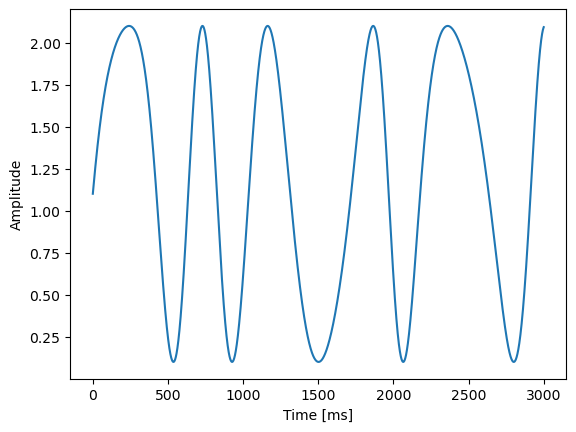

In [3]:
t_samples = np.arange(-100, 3500, 300)
freq_samples = (np.random.random(t_samples.shape) * 1.5 + 0.5)/100

t = np.arange(0, duration, dt)+dt

dx = np.full_like(t, dt)       # Change in x

interpolation = scipy.interpolate.interp1d(t_samples, freq_samples, kind='quadratic')
freq = interpolation(t)

x = (freq * dx ).cumsum()    # Cumsum freq * change in x

signal = np.sin(x)+1+dt

pl.plot(t, signal)
pl.xlabel('Time [ms]')
pl.ylabel("Amplitude")


In [4]:
print(len(signal))

30000


In [5]:
print(len(t))

30000


In [6]:
stim_pgen = nest.Create('inhomogeneous_poisson_generator', 1)
stim_pgen.set({'rate_times': t, 'rate_values': signal})
#idxs = np.where(signal == np.max(signal))[0]
#stim_pgen.set({'rate_times': idxs.astype(float), 'rate_values': signal[idxs].astype(float)})

In [7]:
#### PARAMETERS ###
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 200                  # indegree from excitatory neurons
CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
g = 5.                     # relative inhibitory to excitatory synaptic weight
d = 1.5                    # synaptic transmission delay (ms)

# neuron paramters
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': 20.,           # spike threshold (mV)
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': 20.,          # membrane time constant (ms)
}
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params)
neurons_e = nest.Create('iaf_psc_delta', NE)
neurons_i = nest.Create('iaf_psc_delta', NI)

# create spike detectors
spikes_e = nest.Create('spike_recorder')
# E synapses
syn_exc = {'delay': d, 'weight': w}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# I synapses
syn_inh = {'delay': d, 'weight': - g * w}
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

# spike detector
nest.Connect(neurons_e, spikes_e)

In [8]:
# connect poisson generator using the excitatory connection weight
nest.Connect(stim_pgen, neurons_e, syn_spec=syn_exc)
nest.Connect(stim_pgen, neurons_i, syn_spec=syn_exc)

In [9]:
vm = nest.Create('multimeter', 1, {'record_from': ['V_m'], 'interval': 1})
nest.Connect(vm, neurons_e)

In [10]:
nest.Simulate(len(t))


Oct 21 17:33:49 NodeManager::prepare_nodes [Info]: 
    Preparing 1274 nodes for simulation.

Oct 21 17:33:49 MUSICManager::enter_runtime [Info]: 
    Entering MUSIC runtime with tick = 1 ms

Oct 21 17:33:49 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1274
    Simulation time (ms): 30000
    Number of OpenMP threads: 8
    Number of MPI processes: 1

Oct 21 17:33:54 SimulationManager::run [Info]: 
    Simulation finished.


In [11]:
activity = vm.events
indices = np.sort(np.unique(vm.events['senders']))
states = np.zeros((NE, len(t[1:])))
for idx, i in enumerate(indices):
    states[idx,:] = activity['V_m'][np.where(activity['senders']==i)[0]]

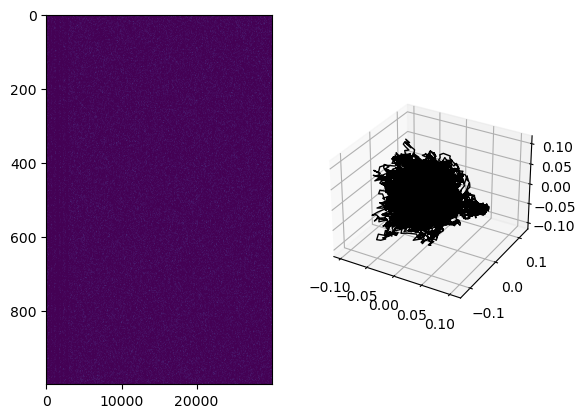

In [12]:
fig = pl.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(states, aspect='auto')
ax2 = fig.add_subplot(122, projection='3d')
pca_fit = PCA(n_components=np.shape(states)[0])
X = pca_fit.fit_transform(states.T)
ax2.plot(X[:, 0], X[:, 1], X[:, 2], color='k', lw=1)

In [13]:
def compute_capacity(x, z):
    """
    Compute capacity to reconstruct z based on linearly combining x

    Parameters
    ----------
    x : np.ndarray
        state matrix(NxT)
    z : np.ndarray
        target output (1xT)

    Returns
    -------
    z_hat : np.ndarray
        Reconstructed (predicted) signal

    """
    reg = LinearRegression(n_jobs=-1, fit_intercept=False).fit(x.T, z)
    W_out = reg.coef_
    z_hat = np.dot(W_out, x)

    covs = np.cov(z_hat, z)[0, 1] ** 2.0
    vars = np.var(z) * np.var(z_hat)
    capacity = covs / vars

    error = np.mean((z - z_hat) ** 2)
    return z_hat, capacity, error

In [14]:
# computes memory capacity at stimulus offset
estimate, capacity, error = compute_capacity(states, signal[1:])
print("Capacity={0}, MSE={1}".format(str(capacity), str(error)))

Capacity=0.5422199969565825, MSE=0.2419350190948915


In [32]:
max_lag = 100.   # [ms] in this example
step_lag = 10.   # [ms] evaluate in discrete time points (alternatively set == 1. for higher resolution)
time_lags = np.arange(0, max_lag, step_lag)+dt

indices = [np.where(idx==t)[0][0] for idx in time_lags]

memory_capacity = []

for idx, lag in zip(indices, time_lags):
    
    # shift the target signal
    if idx > 0:
        shifted_signal = signal[:-idx]
    else:
        shifted_signal = signal
    
    # shift the population states
    st = states[:, idx:]
    
    # compute capacity
    estimate, capacity, error = compute_capacity(st, shifted_signal[:-1])
    
    print("Lag = {0} ms".format(str(lag)))
    print("Capacity={0}, MSE={1}".format(str(capacity), str(error)))
    
    memory_capacity.append(capacity)

Lag = 0.1 ms
Capacity=0.5422490886533422, MSE=0.2419043666678692
Lag = 10.1 ms
Capacity=0.5469506997330748, MSE=0.23857056781079744
Lag = 20.1 ms
Capacity=0.5515316397857453, MSE=0.23555773276742648
Lag = 30.1 ms
Capacity=0.5566200095812917, MSE=0.23245951869001205
Lag = 40.1 ms
Capacity=0.5628053982367396, MSE=0.22896836949890112
Lag = 50.1 ms
Capacity=0.5704638537279444, MSE=0.22469785165164474
Lag = 60.1 ms
Capacity=0.5804770123525844, MSE=0.2187760614347354
Lag = 70.1 ms
Capacity=0.5872136599634846, MSE=0.21557180932012068
Lag = 80.1 ms
Capacity=0.5943856431683453, MSE=0.21227849919500769
Lag = 90.1 ms
Capacity=0.6015633386010111, MSE=0.20892906501262726


In [30]:
print(len(signal))


30000


Total capacity: 56.942603438035626 ms


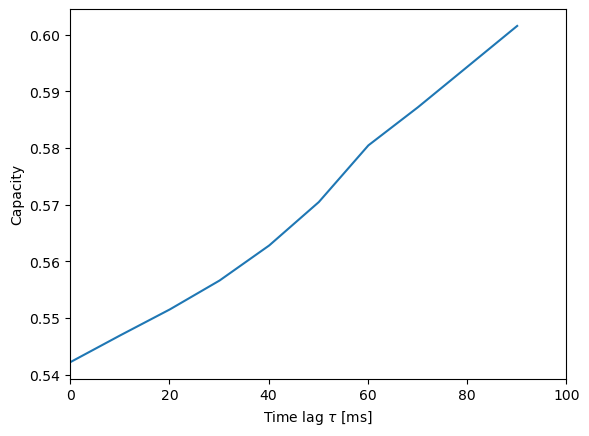

In [34]:
fig, ax = pl.subplots()
ax.plot(time_lags, memory_capacity)
ax.set_xlim([0., max_lag])
ax.set_xlabel(r'Time lag $\tau$ [ms]')
ax.set_ylabel(r'Capacity')
print("Total capacity: {0} ms".format(str(np.sum(memory_capacity)*step_lag)))